In [1]:
import sys
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from tqdm import tqdm
from os import listdir

%matplotlib inline

In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [3]:
MODEL_NAME = 'ssd_inception_v2_coco_11_06_2017'
PATH_TO_VOC = '../data/VOC2012/'
PATH_TO_CKPT = '../models/' + MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_VOC_LABELS = PATH_TO_VOC + 'pascal_label_map.pbtxt'
PATH_TO_COCO_LABELS = '../data/COCO/mscoco_label_map.pbtxt'
PATH_TO_IMGS = PATH_TO_VOC + 'JPEGImages/'
VOC_NUM_CLASSES = 20
COCO_NUM_CLASSES = 90

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [5]:
voc_label_map = label_map_util.load_labelmap(PATH_TO_VOC_LABELS)
voc_categories = label_map_util.convert_label_map_to_categories(voc_label_map, max_num_classes=VOC_NUM_CLASSES, use_display_name=True)
voc_category_index = label_map_util.create_category_index(voc_categories)

coco_label_map = label_map_util.load_labelmap(PATH_TO_COCO_LABELS)
coco_categories = label_map_util.convert_label_map_to_categories(coco_label_map, max_num_classes=COCO_NUM_CLASSES, use_display_name=True)
coco_category_index = label_map_util.create_category_index(coco_categories)

# Поскольку названия не совпадают, пришлось найти соответствие между классами вручную
coco_to_voc = {
    1: 15,
    2: 2,
    3: 7,
    4: 14,
    5: 1,
    6: 6,
    7: 19,
    9: 4,
    16: 3,
    17: 8,
    18: 12,
    19: 13,
    20: 17,
    21: 10,
    44: 5,
    62: 9,
    64: 16,
    65: 18,
    67: 11,
    72: 20
}

print(len(coco_to_voc))

20


In [6]:
voc_name_to_class = {}

for value in voc_category_index.values():
    voc_name_to_class[value['name']] = value['id']
    
voc_name_to_class

{'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [7]:
TEST_IMAGE_PATHS = ['2007_000027.jpg', '2007_000032.jpg', 
                    '2007_000033.jpg', '2007_000042.jpg']
TEST_IMAGE_PATHS = list(map(lambda img: PATH_TO_IMGS + img, TEST_IMAGE_PATHS))

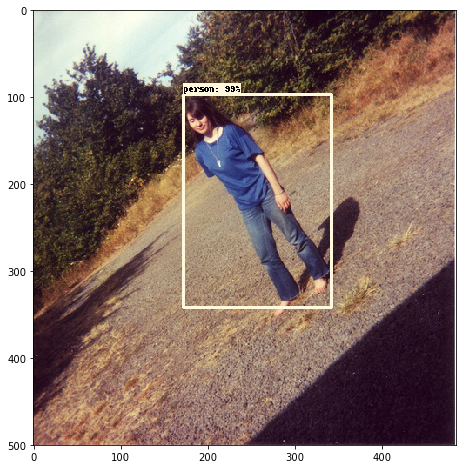

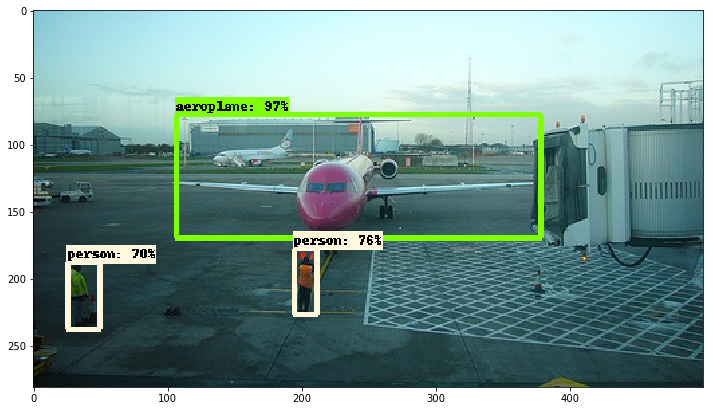

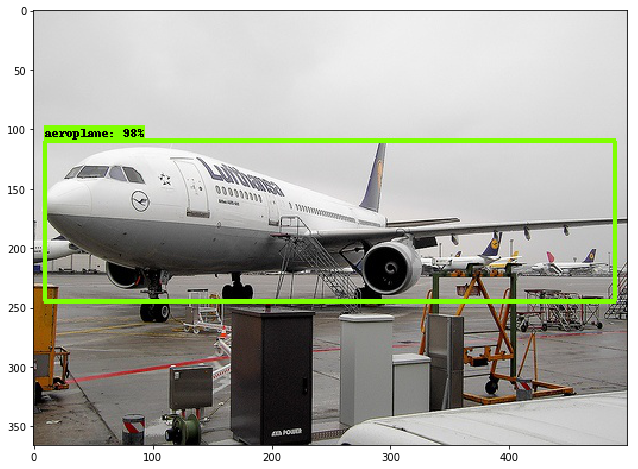

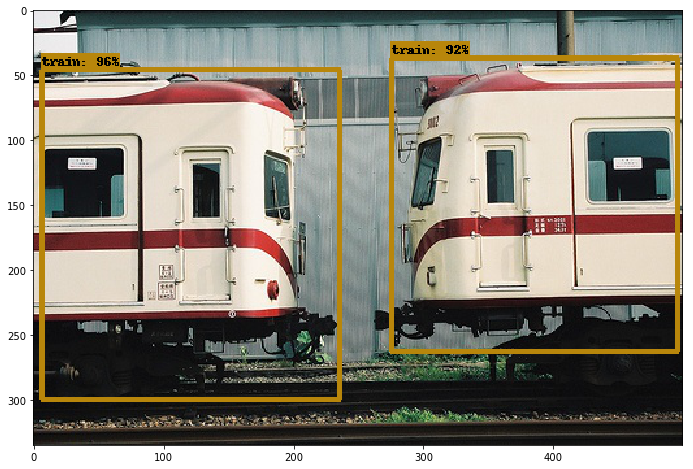

In [8]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            img_src = cv2.imread(image_path)
            img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
            
            img = np.copy(img_src)
            image_np_expanded = np.expand_dims(img, axis=0)

            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            classes[0] = list(map(lambda coco_class: 0 if coco_class not in coco_to_voc else \
                                  coco_to_voc[coco_class], classes[0]))
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              img,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              voc_category_index,
              use_normalized_coordinates=True,
              line_thickness=4)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(img)
            plt.show()

In [9]:
print('loading annotations...')

def load_annos():
    path_to_anno = PATH_TO_VOC + 'Annotations/'

    annos = {}
    i = 0

    for file in tqdm(listdir(path_to_anno)):
        xml = et.parse(path_to_anno + file)
        root = xml.getroot()

        objects = []
        classes = []

        for obj in root.iter('object'):
            coords = [0, 0, 0, 0]
            for child in list(obj):
                if child.tag == 'name':
                    name = child.text
                if child.tag == 'bndbox':
                    for coord in list(child):
                        if coord.tag == 'xmin':
                             coords[0] = int(coord.text)
                        if coord.tag == 'ymin':
                             coords[1] = int(coord.text)
                        if coord.tag == 'xmax':
                             coords[2] = int(coord.text)
                        if coord.tag == 'ymax':
                             coords[3] = int(coord.text)

            classes.append(voc_name_to_class[name])
            objects.append(coords)

        img = file.split('.')[0] + '.jpg'
        annos[img] = [objects, classes]

    return annos

loading annotations...


In [10]:
voc_annos = load_annos()

100%|██████████| 17125/17125 [00:01<00:00, 11741.94it/s]


In [11]:
def iou(box_1, box_2):
    xmin_1 = box_1[0]
    ymin_1 = box_1[1]
    xmax_1 = box_1[2]
    ymax_1 = box_1[3]
    
    xmin_2 = box_2[0]
    ymin_2 = box_2[1]
    xmax_2 = box_2[2]
    ymax_2 = box_2[3]
    
    xmin_inter = max(xmin_1, xmin_2)
    ymin_inter = max(ymin_1, ymin_2)
    xmax_inter = min(xmax_1, xmax_2)
    ymax_inter = min(ymax_1, ymax_2)

    intersection = (xmax_inter - xmin_inter) * (ymax_inter - ymin_inter)
    if xmin_inter > xmax_inter or ymin_inter > ymax_inter:
        intersection = 0
    square_1 = (xmax_1 - xmin_1) * (ymax_1 - ymin_1)
    square_2 = (xmax_2 - xmin_2) * (ymax_2 - ymin_2)
    union = square_1 + square_2 - intersection
    
    return intersection / union

In [12]:
def test_detection(gt_boxes, real_boxes, gt_labels, real_labels):
    gt_to_real = {}
    ious = []
    
    for i, gt_box in enumerate(gt_boxes):
        max_iou = 0.
        gt_to_real[i] = 0
        for j, real_box in enumerate(real_boxes):
            iou_value = iou(gt_box, real_box)
            if iou_value > max_iou:
                max_iou = iou_value
                gt_to_real[i] = j
        ious.append(max_iou)
    
    n_boxes = min(len(real_boxes), len(gt_boxes))
    
    count_trues = np.count_nonzero([gt_labels[i] == real_labels[gt_to_real[i]] for i in range(n_boxes)])
    return ious, count_trues            

In [13]:
def absolute_bbox(box, size):
    return [size[1] * float(box[1]), size[0] * float(box[0]),
            size[1] * float(box[3]), size[0] * float(box[2])]

In [14]:
def filter_boxlabels(real_boxes, real_labels, scores, threshold=0.1):
    boxes = []
    labels = []
    for i in range(len(scores)):
        if scores[i] > threshold:
            boxes.append(real_boxes[i])
            labels.append(real_labels[i])
    
    return boxes, labels

In [15]:
iou_results = []
accuracy = 0
num_objects = 0

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for img_filename, item in tqdm(voc_annos.items()):
            img = cv2.imread(PATH_TO_IMGS + img_filename)
            image_np_expanded = np.expand_dims(img, axis=0)

            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            real_boxes = list(map(lambda bbox: absolute_bbox(bbox, img.shape), boxes[0]))
            real_classes = list(map(lambda coco_class: 0 if coco_class not in coco_to_voc else \
                                  coco_to_voc[coco_class], classes[0]))
            
            real_boxes, real_classes = filter_boxlabels(real_boxes, real_classes, scores[0])
            
            gt_objs = item[0]
            gt_classes = item[1]
            
            ious, count_trues = test_detection(gt_objs, real_boxes, gt_classes, real_classes)
            
            num_objects += len(gt_classes)
            accuracy += count_trues
            for i in ious:
                iou_results.append(i)

    accuracy = accuracy / num_objects
    iou_results = np.mean(iou_results)
    print('accuracy: ' + str(accuracy))
    print('IoU: ' + str(iou_results))

100%|██████████| 17125/17125 [1:10:53<00:00,  4.03it/s]

accuracy: 0.7806069061737008
IoU: 0.688805994677
